### Find a "good" session, see if PCA shows anything

In [109]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [111]:
def get_results(session, model, mode, alpha): 
    res_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat.pickle"
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID

    shuffle_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat_shuffles.pickle"
    shuffles = pd.read_pickle(os.path.join(OUTPUT_DIR, shuffle_name))
    # sig_bounds = shuffles.groupby("split_idx").apply(lambda group: glm_utils.calculate_sig_stats(group, alpha, 1, "score")).reset_index()
    sig_bounds = glm_utils.calculate_sig_stats(shuffles, alpha, 1, "score")

    merged = pd.merge(res, sig_bounds, on=["UnitID"])
    return merged
# sig = glm_utils.calculate_sig_stats(shuffles, )
# return res
# glm_res = pd.concat(sessions.apply(lambda x: get_agg_glm_res(x.session_name), axis=1).values)

In [112]:
model = "LinearNoInt"
mode = "FiringRate"
alpha = 0.05

glm_res = pd.concat(sessions.apply(lambda x: get_results(x.session_name, model, mode, alpha), axis=1).values)
positions = spike_utils.get_unit_positions(sessions)
glm_res = pd.merge(positions, glm_res, on="PseudoUnitID")

In [113]:
glm_res.columns

Index(['Channel', 'Unit', 'SpikeTimesFile', 'UnitID_x', 'electrode_id', 'x',
       'y', 'z', 'distance', 'in_brain', 'tissue', 'structure_level1',
       'structure_level2', 'structure_level3', 'structure_level4',
       'structure_level5', 'structure_level6', 'structure_potential',
       'session_x', 'PseudoUnitID', 'manual_structure', 'UnitID_y',
       'TimeBins_x', 'score', 'SQUARE_coef', 'STAR_coef', 'CYAN_coef',
       'RIPPLE_coef', 'POLKADOT_coef', 'SWIRL_coef', 'CIRCLE_coef',
       'MAGENTA_coef', 'session_y', 'TimeBins_y', 'sig_bound', 'GREEN_coef',
       'ESCHER_coef', 'TRIANGLE_coef', 'YELLOW_coef'],
      dtype='object')

In [114]:
good_res = glm_res[glm_res.score > glm_res.sig_bound]
good_res.groupby("session_x").count()

,Channel,Unit,SpikeTimesFile,UnitID_x,electrode_id,x,y,z,distance,in_brain,...,SWIRL_coef,CIRCLE_coef,MAGENTA_coef,session_y,TimeBins_y,sig_bound,GREEN_coef,ESCHER_coef,TRIANGLE_coef,YELLOW_coef
session_x,,,,,,,,,,,,,,,,,,,,,
20180705,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,0,0,1,1
20180709,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,0,0,0,0
201807250001,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,0,0,0,1
20180801,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20180802,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,0,4,4
20180803,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
20180806,2,2,2,2,2,2,2,2,2,2,...,0,2,2,2,2,2,2,0,2,0
20180808,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
20180912,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,0,1


In [115]:
session = 20180801
feats_of_interest = ["POLKADOT", "GREEN"]

num_bins = 10
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber")
beh = behavioral_utils.get_feature_values_per_session(session, beh)
beh = behavioral_utils.get_max_feature_value(beh, num_bins)
beh = behavioral_utils.get_relative_block_position(beh, num_bins)
beh["TrialIdx"] = np.arange(len(beh))


fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)

agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()

agg = pd.merge(beh[["TrialNumber", "TrialIdx", "BlockNumber", "CurrentRule", "MaxValueBin", "MaxValue"]], agg, on="TrialNumber")
agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

# beh = behavioral_utils.filter_max_feat_correct(beh)
# beh = beh[beh.CurrentRule.isin(feats_of_interest)]
agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]


In [116]:
mode = "ZFiringRate"
agg = agg.sort_values(by=["TrialIdx", "UnitID"])
vals = agg[mode].values.reshape(len(agg.TrialIdx.unique()), len(agg.UnitID.unique()))

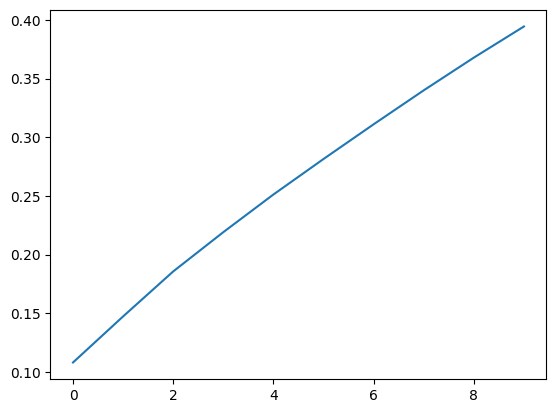

In [117]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components).fit(vals)
plt.plot(np.cumsum(pca.explained_variance_ratio_[:10]))
res = pca.fit_transform(vals)

In [118]:
for i in range(10):
    beh[f"PC{i}"] = res[:, i]

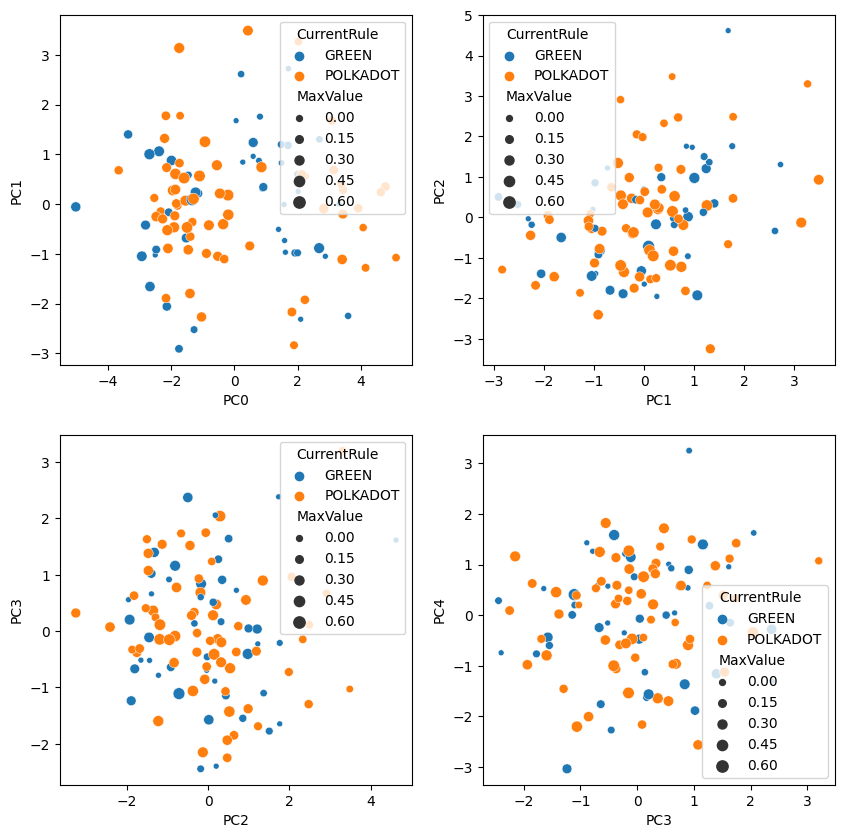

In [123]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sub_beh = beh[beh.CurrentRule.isin(feats_of_interest)]
# sub_beh = behavioral_utils.filter_max_feat_correct(sub_beh)
# sub_beh = sub_beh[sub_beh.CurrentRule.isin(["CYAN"])]

for i in range(4):

    ax = axs[int(i/2), i % 2]
    sns.scatterplot(data=sub_beh, x=f"PC{i}", y=f"PC{i+1}", hue="CurrentRule", size="MaxValue", ax=ax)

In [107]:
sub_beh

,index,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
16,16,39,2,16,NaN,4536,Correct,0.0,7,GREEN,...,-3.684536,5.287782,-3.725571,6.396631,-2.068447,1.249953,3.639965,-1.201500,1.429669,-0.196724
17,17,40,2,17,NaN,4555,Correct,0.0,7,GREEN,...,-14.668699,13.736953,3.741348,-3.884366,4.881157,0.080232,2.853930,7.905860,-3.131234,1.299176
18,18,41,2,18,NaN,4333,Correct,0.0,7,GREEN,...,-5.297216,12.216258,1.960714,-5.226968,-3.142376,0.099387,-2.383082,-4.385872,-5.623082,-4.854359
19,19,42,2,19,NaN,4562,Correct,0.0,7,GREEN,...,4.614464,7.428995,1.030093,-1.014478,-3.028666,6.251937,9.045663,-0.966054,-1.689411,1.447710
154,154,177,6,19,NaN,4242,Correct,0.0,7,GREEN,...,-9.746431,4.348381,14.668259,-4.880993,1.011428,-4.251166,1.568665,-0.782126,-0.364657,-0.888873
155,155,178,6,20,NaN,4517,Correct,0.0,7,GREEN,...,-13.993144,-11.276201,12.299085,5.093887,-5.637301,6.874675,8.562620,0.047375,-0.993292,-2.538556
156,156,179,6,21,NaN,4570,Correct,0.0,7,GREEN,...,-10.022773,-7.678898,3.816928,10.661718,5.486336,-4.189006,10.717732,-0.602916,5.778579,-0.935371
157,157,180,6,22,NaN,4576,Correct,0.0,7,GREEN,...,-17.113045,-3.423026,6.856231,-1.891857,2.829410,6.326188,2.484412,11.510716,-0.584020,-0.996458
158,158,181,6,23,NaN,4572,Correct,0.0,7,GREEN,...,-10.048415,16.848329,4.393233,-1.616838,7.872558,6.404601,-2.939362,-3.540627,2.419341,-3.951954
159,159,182,6,24,NaN,4267,Correct,0.0,7,GREEN,...,-15.494194,4.701014,10.298833,11.688935,-4.292267,2.016714,2.065771,-4.947172,-6.553800,-4.162561
